### feature engineering

为什么需要对数据进行特征工程的处理呢？我认为有这么几个原因，一是数据的实际采集是会有错误的，就比如填表之类的永远会有人填错，特征工程就可以通过数据分析后，将这些异常的值给剔除；二是数据样本可能不是很大，对数据进行分析找出其中一些规律可以让训练出的模型做出更贴合实际的推断；三是有些数据之间是有内在关系的，比方说时间段和时刻，可能时间段长短对最终影响更大，但是模型不一定能从数据中找到这样的规律，或者找到这样的规律需要很大的计算成本。所以特征工程是一个比较灵活的操作，这一部分因人而异，体现了一个数据工作者对数据的敏感程度。

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
%matplotlib inline

In [3]:
train = pd.read_csv('used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('used_car_testA_20200313.csv', sep=' ')
print(train.shape)
print(test.shape)

(150000, 31)
(50000, 30)


In [4]:
train.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


以上一部分是导入数据和大略看以下数据，和之前的操作相似，敲一遍代码加深印象

In [5]:
def outliers_proc(data, col_name, scale=3):
    def box_plot_outliers(data_ser, box_scale):
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)
    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0]|rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149032,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149033,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149034,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149035,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014


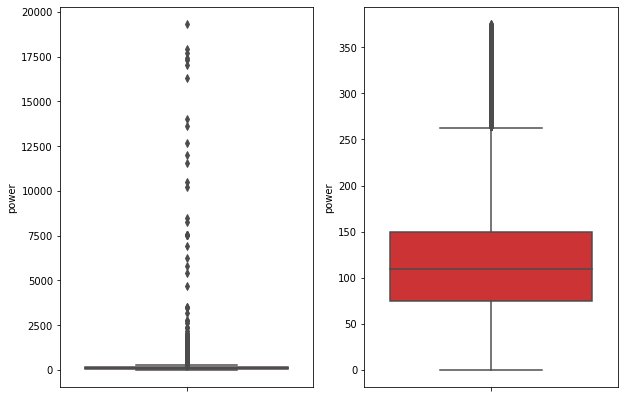

In [6]:
outliers_proc(train, 'power', scale=3)

Delete number is: 114
Now column number is: 149886
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      114.000000
mean      3811.087719
std       4647.584177
min        903.000000
25%       1162.500000
50%       1598.000000
75%       3488.500000
max      19312.000000
Name: power, dtype: float64


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149881,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149882,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149883,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149884,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014


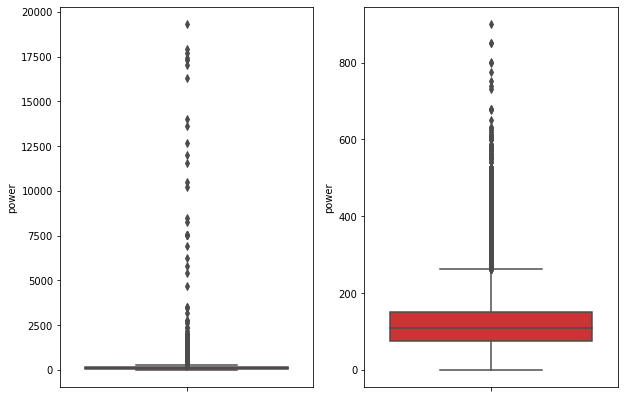

In [7]:
outliers_proc(train, 'power', scale=10)

对比了scale取3和10的两种情况，可以看出scale取值越大，剔除的数据越少

### 1.构造特征

In [8]:
train['train'] = 1
test['train'] = 0
data = pd.concat([train, test], ignore_index=True, sort=False)
# pandas的concat操作会将两个dataframe连接起来，其中有两个参数，
# 其一是ignore_index，如果选择False，那么则会将每个dataframe的index保留
# 其二是sort，如果选择False,那么就不会刻意去排序
data

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,1
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,1
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,1
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,20903,19960503,4.0,4,4.0,0.0,0.0,116,15.0,...,0.130044,0.049833,0.028807,0.004616,-5.978511,1.303174,-1.207191,-1.981240,-0.357695,0
199996,199996,708,19991011,0.0,0,0.0,0.0,0.0,75,15.0,...,0.108095,0.066039,0.025468,0.025971,-3.913825,1.759524,-2.075658,-1.154847,0.169073,0
199997,199997,6693,20040412,49.0,1,0.0,1.0,1.0,224,15.0,...,0.105724,0.117652,0.057479,0.015669,-4.639065,0.654713,1.137756,-1.390531,0.254420,0
199998,199998,96900,20020008,27.0,1,0.0,0.0,1.0,334,15.0,...,0.000490,0.137366,0.086216,0.051383,1.833504,-2.828687,2.465630,-0.911682,-2.057353,0


In [9]:
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days
data['used_time'].isnull().sum()
# 这一块就学习到了，使用时间段而不是时刻，不过到底哪个效果好还是需要实践才知道

15101

In [10]:
data['city'] = data['regionCode'].apply(lambda x: str(x)[:-3])
set(data['city'])
# 这波操作666，还搜集了德国的信息，
# 哈哈忽然发现其中数据工程师不是对着数据关门练功而是要努力让自己博学

{'', '1', '2', '3', '4', '5', '6', '7', '8'}

In [11]:
train_gb = train.groupby("brand")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

In [12]:
data.head()
# 增加很多行关于品牌的信息，这个也是可以理解的方法，毕竟汽车的品牌一般都是买车重点关注对象

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,train,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,1,4385.0,1,10217.0,59900.0,1800.0,13.0,36902172.0,4681.293524,3611.49
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,1,4757.0,4,13794.0,99900.0,6499.0,15.0,127916065.0,9369.631497,9272.64
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,1,4382.0,2,1458.0,45000.0,8500.0,100.0,14373814.0,5425.058140,9851.83
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,1,7125.0,,14249.0,98000.0,5400.0,15.0,120700489.0,8988.307535,8470.21
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,1,1531.0,6,4665.0,31500.0,2300.0,20.0,15424120.0,3343.624586,3305.64


In [13]:
# 分桶
# 感觉分桶和物以类聚比较接近，或者说很多时候函数是分段函数
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [14]:
# 构造完特征后，删除原始数据
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [15]:
print(data.shape)

(200000, 39)


In [16]:
# 目前的数据其实已经可以给树模型使用了，所以我们导出一下
data.to_csv('data_for_tree.csv', index=0)

### 2.LR和NN使用的数据

我觉得LR和NN比较矫情，对数据要求比较苛刻，一是数据要大致符合正太分布，二是str之类的变量需要使用那种会把数据矩阵扩充成很大的one-hot，其实目前还不是很清楚为什么要这么做

(200000, 370)


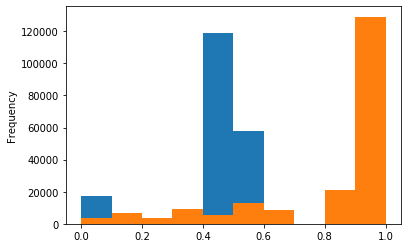

In [17]:
# 我们对其取 log，在做归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()
# 所以我们可以直接做归一化
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

# 除此之外 还有我们刚刚构造的统计量特征：
# 'brand_amount', 'brand_price_average', 'brand_price_max',
# 'brand_price_median', 'brand_price_min', 'brand_price_std',
# 'brand_price_sum'
# 这里不再一一举例分析了，直接做变换，
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) / 
                        (np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) / 
                               (np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) / 
                           (np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
                              (np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) / 
                           (np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) / 
                           (np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) / 
                           (np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))

# 对类别特征进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

print(data.shape)
data.columns

# 这份数据可以给 LR 用
data.to_csv('data_for_lr.csv', index=0) # 没有导出来，等想清楚为啥这么折腾再这么操作一波

### 3 特征筛选的方式
特征选择技术可以精简掉无用的特征，以降低最终模型的复杂性，它的最终目的是得到一个
简约模型，在不降低预测准确率或对预测准确率影响不大的情况下提高计算速度。为了得到这样的模型，有些特征选择技术需要训练不止一个待选模型。换言之，特征选择不是为了减
少训练时间（实际上，一些技术会增加总体训练时间），而是为了减少模型评分时间。
粗略地说，特征选择技术可以分为以下三类。

##### 3.1 过滤式

过滤技术对特征进行预处理，以除去那些不太可能对模型有用处的特征。例如，我们可
以计算出每个特征与响应变量之间的相关性或互信息，然后过滤掉那些在某个阈值之下
的特征。过滤技术的成本比下面描述的打包技
术低廉得多，但它们没有考虑我们要使用的模型，因此，它们有可能无法为模型选择出
正确的特征。我们最好谨慎地使用预过滤技术，以免在有用特征进入到模型训练阶段之
前不经意地将其删除。

In [18]:
# 1.过滤式
# 相关性分析
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

0.5773425426332196
-0.4097783640876424
0.05438301230221679
0.38875954584355615
0.2587402623951201
0.39159165603497703


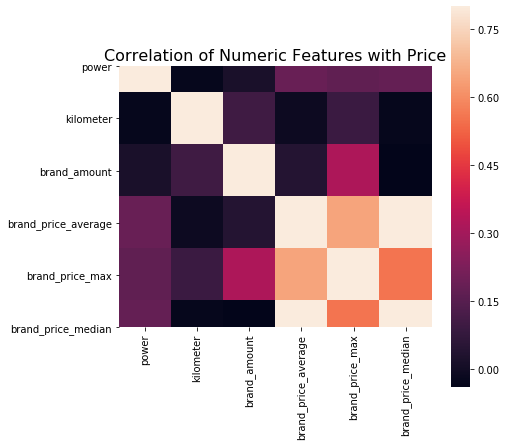

In [19]:
# 当然也可以直接看图
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

##### 3.2 包裹式

这些技术的成本非常高昂，但它们可以试验特征的各个子集，这意味着我们不会意外地
删除那些本身不提供什么信息但和其他特征组合起来却非常有用的特征。打包方法将模
型视为一个能对推荐的特征子集给出合理评分的黑盒子。它们使用另外一种方法迭代地
对特征子集进行优化。

In [20]:
# 2.包裹式
# k_feature 太大会很难跑，没服务器，所以提前 interrupt 了
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
x = data.drop(['price'], axis=1)
x = x.fillna(0)
y = data['price']
sfs.fit(x, y)
sfs.k_feature_names_ 

# 没带动，先不跑了

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

##### 3.2 包裹式

这种方法将特征选择作为模型训练过程的一部分。例如，特征选择是决策树与生俱来的
一种功能，因为它在每个训练阶段都要选择一个特征来对树进行分割。另一个例子是
ℓ
1 正则项，它可以添加到任意线性模型的训练目标中。ℓ
1 正则项鼓励模型使用更少的特
征，而不是更多的特征，所以又称为模型的稀疏性约束。嵌入式方法将特征选择整合为
模型训练过程的一部分。它们不如打包方法强大，但成本也远不如打包方法那么高。与
过滤技术相比，嵌入式方法可以选择出特别适合某种模型的特征。从这个意义上说，嵌
入式方法在计算成本和结果质量之间实现了某种平衡。